In [1]:
# ---- 1. Imports ----
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
import sys
print(sys.executable)


c:\Anaconda\python.exe


In [4]:
# ---- 2. Load data ----
df = pd.read_csv("data.csv")   # <-- change path if needed
print(df.head())
print(df.info())

   record_ID      week  store_id  sku_id  total_price  base_price  \
0          1  17/01/11      8091  216418      99.0375    111.8625   
1          2  17/01/11      8091  216419      99.0375     99.0375   
2          3  17/01/11      8091  216425     133.9500    133.9500   
3          4  17/01/11      8091  216233     133.9500    133.9500   
4          5  17/01/11      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  
0                0               0          20  
1                0               0          28  
2                0               0          19  
3                0               0          44  
4                0               0          52  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  o

In [5]:
# ---- 3. Basic preprocessing ----
# Fill missing values in numeric columns with mean
numeric_cols = [
    'record_ID',
    'store_id',
    'sku_id',
    'total_price',
    'base_price',
    'is_featured_sku',
    'is_display_sku',
    'units_sold'
]

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [6]:
# ---- 4. Create a key like before (week + store_id) ----
df['key'] = df['week'].astype(str) + '_' + df['store_id'].astype(str)

# Remove columns that are not useful for time-series prediction
df = df.drop(
    ['record_ID', 'week', 'store_id', 'sku_id',
     'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'],
    axis=1
)

In [7]:
df = df.groupby('key').sum()

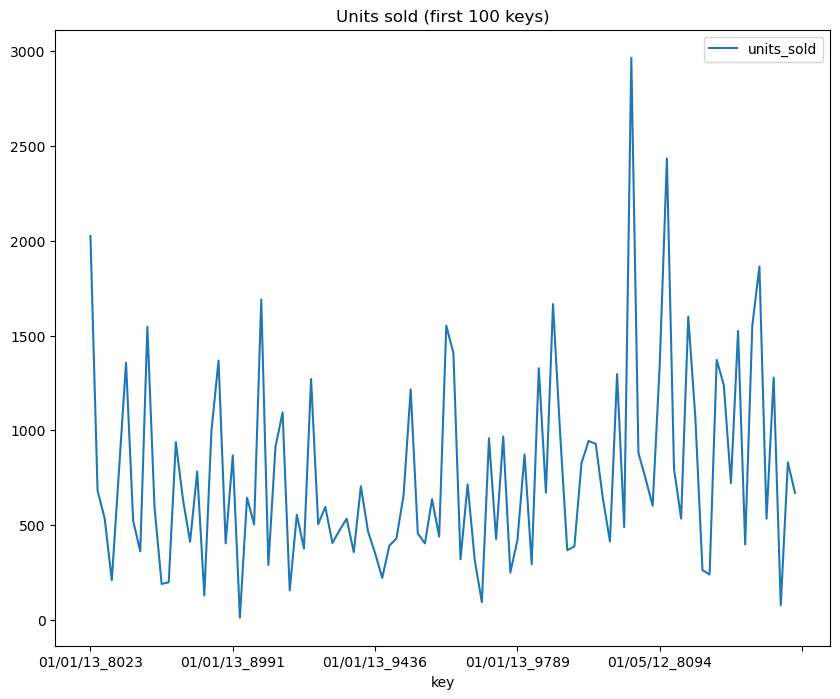

In [9]:
# ---- 5. Visualize the data ----
df[:100].plot(figsize=(10, 8))
plt.title("Units sold (first 100 keys)")
plt.show()

In [10]:
# ---- 6. Create lag features (day_1 ... day_4) ----
df['day_1'] = df['units_sold'].shift(-1)
df['day_2'] = df['units_sold'].shift(-2)
df['day_3'] = df['units_sold'].shift(-3)
df['day_4'] = df['units_sold'].shift(-4)

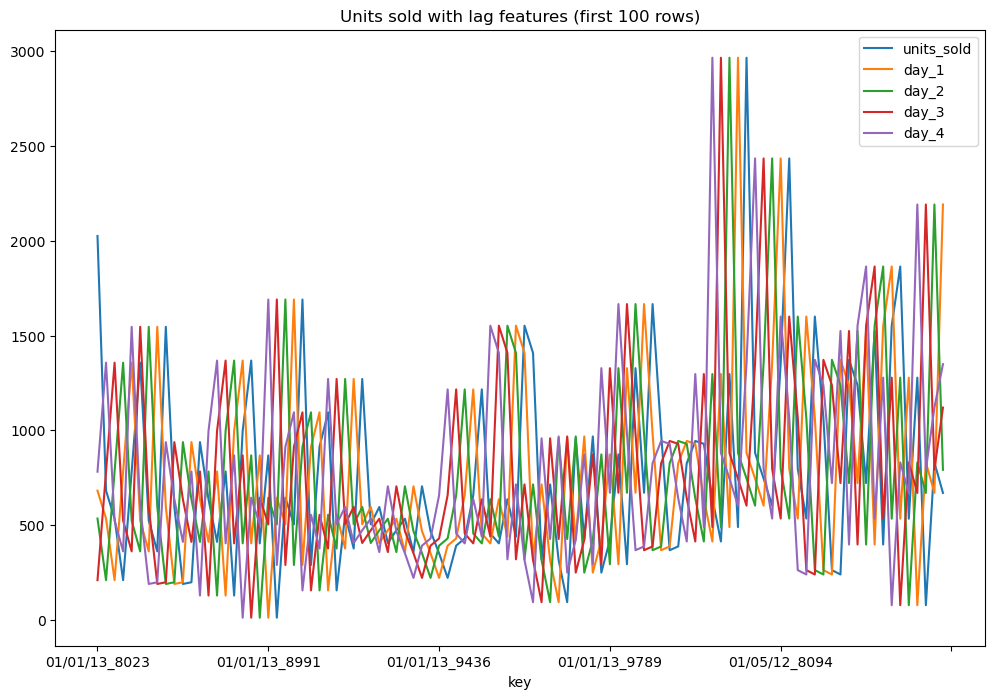

In [11]:

# Drop rows with NaN created by shifting
df = df.dropna()
df[:100].plot(figsize=(12, 8))
plt.title("Units sold with lag features (first 100 rows)")
plt.show()

In [12]:
 #---- 7. Build feature matrix X and target y ----
feature_cols = ['day_1', 'day_2', 'day_3', 'day_4']
X = df[feature_cols].values
y = df['units_sold'].values

In [13]:
# ---- 8. Train–test split (same idea as your 15% split, no shuffle) ----
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=False
)


In [14]:
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

X_train: (8394, 4)
X_test : (1482, 4)
y_train: (8394,)
y_test : (1482,)


R^2 Score for Random Forest Regression: 0.6867314781962205


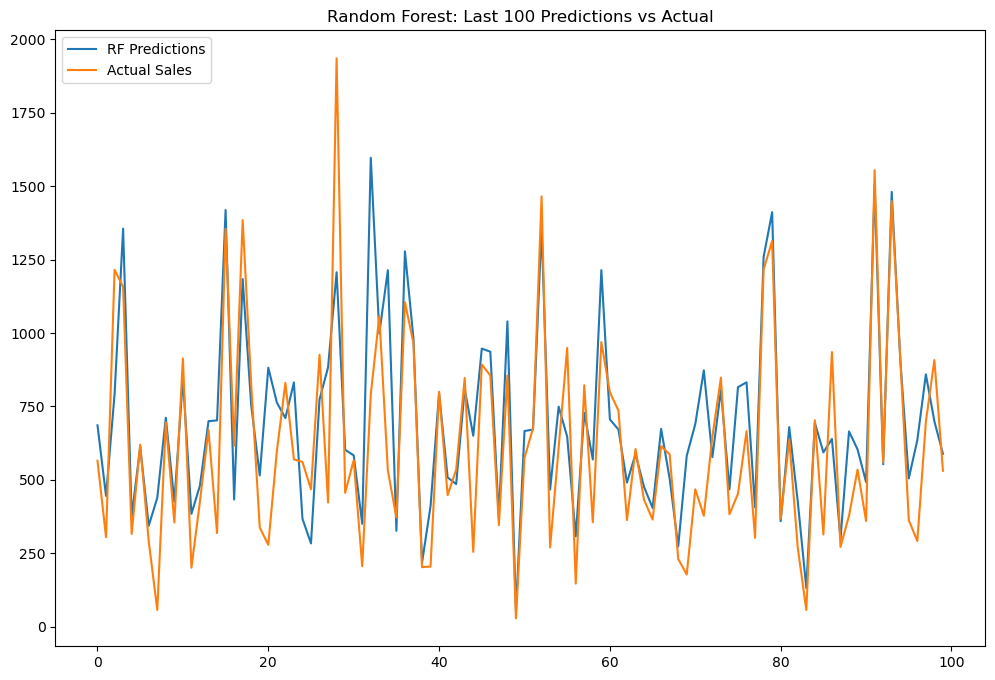

In [16]:
# ---- 9. Random Forest Regression ----
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)
print("R^2 Score for Random Forest Regression:",
      rf_regressor.score(X_test, y_test))

plt.figure(figsize=(12, 8))
plt.plot(y_pred_rf[-100:], label='RF Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.title("Random Forest: Last 100 Predictions vs Actual")
plt.show()

R^2 Score for XGBoost: 0.5886945710071327


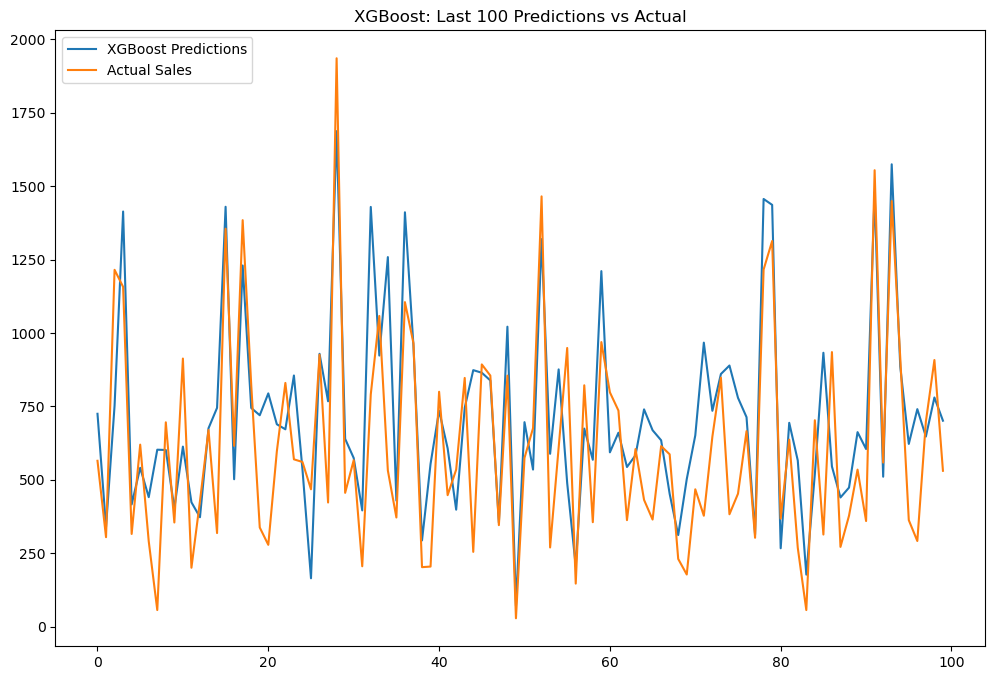

In [17]:
# ---- 10. XGBoost Regression ----
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror",  # avoid deprecation warning
    random_state=42
)
xgb_regressor.fit(X_train, y_train)

y_pred_xgb = xgb_regressor.predict(X_test)
print("R^2 Score for XGBoost:", xgb_regressor.score(X_test, y_test))

plt.figure(figsize=(12, 8))
plt.plot(y_pred_xgb[-100:], label='XGBoost Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.title("XGBoost: Last 100 Predictions vs Actual")
plt.show()

Random search grid:
{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 21, 27, 33, 38, 44, 50, 56, 62, 67, 73, 79, 85, 91, 96, 102, 108, 114, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Anaconda\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_paramet

Best parameters found:
{'n_estimators': 205, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
R^2 Score for Random Forest Regression       : 0.6746611437970452
Adjusted R^2 Score for Random Forest Regression: 0.6737800636177549


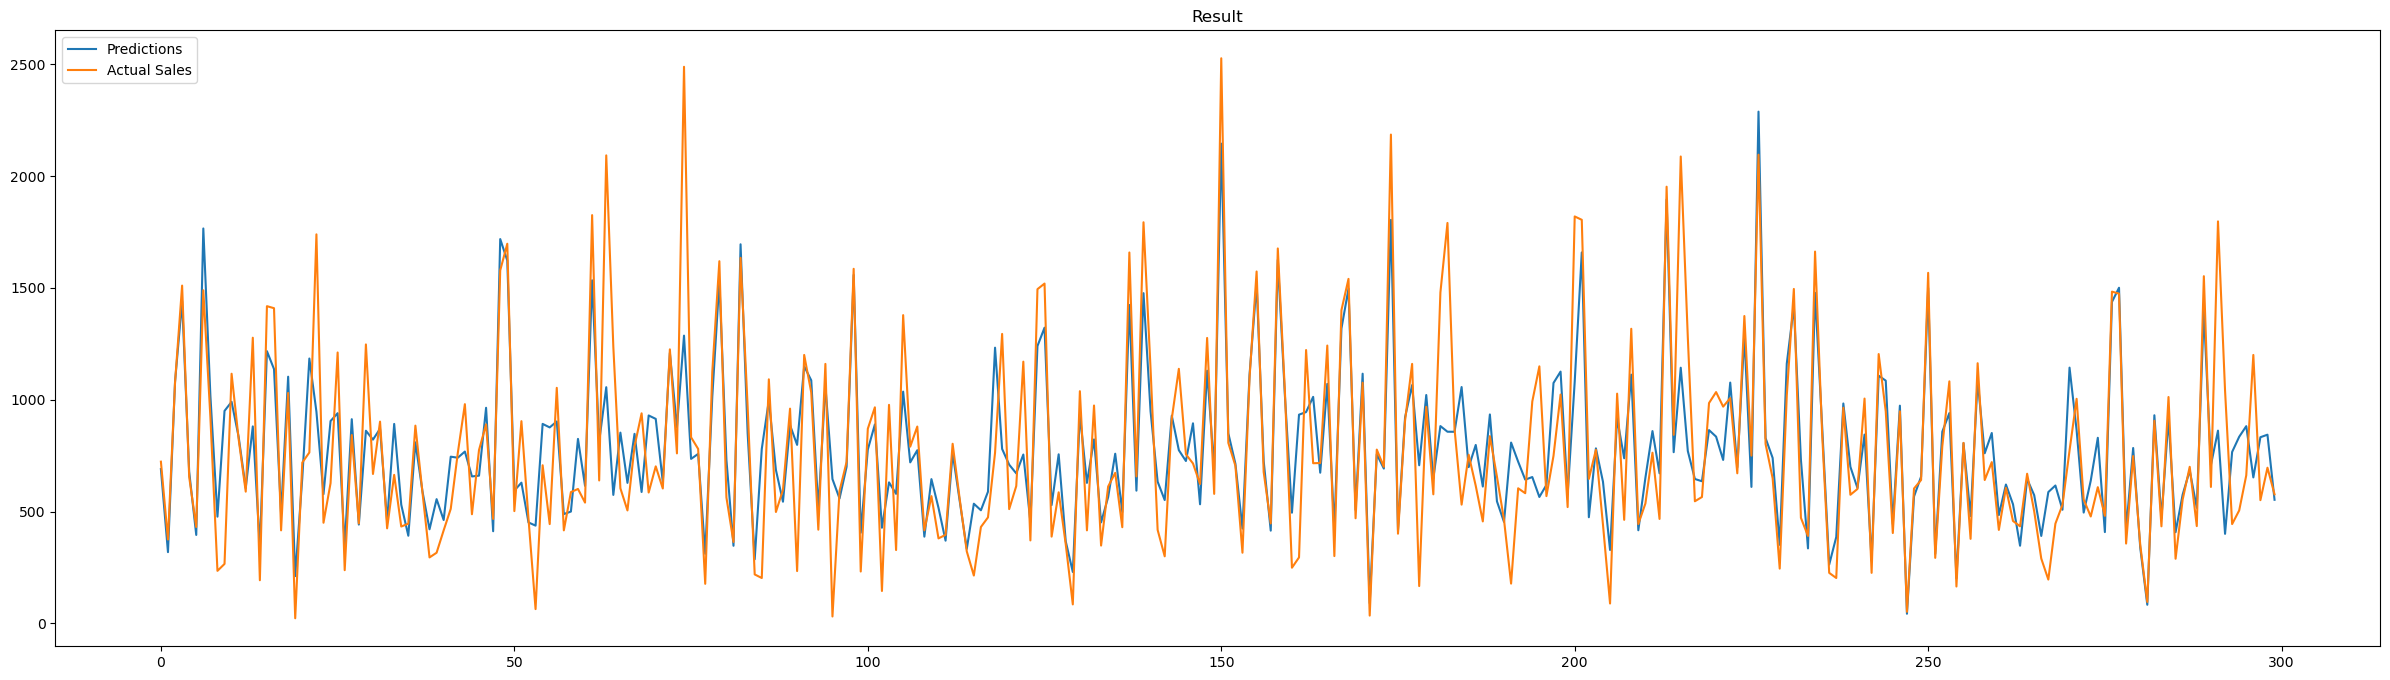

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# -----------------------------
# 1. Define hyperparameter grid
# -----------------------------

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=250, num=10)]

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=120, num=20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

print("Random search grid:")
print(random_grid)

# -----------------------------------------
# 2. Randomized search with cross-validation
# -----------------------------------------

# Base model
rf = RandomForestRegressor(random_state=0)

# Random search of parameters
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=10,          # number of random combinations to try
    cv=3,               # 3-fold cross-validation
    verbose=2,
    random_state=0,
    n_jobs=-1           # use all cores
)

# Fit on training data
rf_random.fit(X_train, y_train)

# Best parameters and model
print("Best parameters found:")
print(rf_random.best_params_)

best_random = rf_random.best_estimator_

# -----------------------------
# 3. Evaluation on test set
# -----------------------------

y_pred = best_random.predict(X_test)

r2 = best_random.score(X_test, y_test)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("R^2 Score for Random Forest Regression       :", r2)
print("Adjusted R^2 Score for Random Forest Regression:", adj_r2)

# -----------------------------
# 4. Plot predictions vs actual
# -----------------------------

plt.rcParams["figure.figsize"] = (30, 8)
start_idx = 500  # change if your test set is smaller
end_idx = 800

plt.plot(y_pred[start_idx:end_idx], label="Predictions")
plt.plot(y_test[start_idx:end_idx], label="Actual Sales")
plt.title("Result")
plt.legend(loc="upper left")
plt.savefig("final.png")
plt.show()
